In [1]:
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
import math
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
df = pd.read_csv("data/RickAndMortyScripts.csv")
df.head()

,index,season no.,episode no.,episode name,name,line
0,0,1,1,Pilot,Rick,Morty! You gotta come on. Jus'... you gotta co...
1,1,1,1,Pilot,Morty,"What, Rick? What’s going on?"
2,2,1,1,Pilot,Rick,"I got a surprise for you, Morty."
3,3,1,1,Pilot,Morty,It's the middle of the night. What are you tal...
4,4,1,1,Pilot,Rick,"Come on, I got a surprise for you. Come on, h..."


In [2]:
df.describe()

,index,season no.,episode no.
count,1905.000000,1905.000000,1905.000000
mean,1190.003675,2.155381,3.208399
std,721.719735,0.832004,2.247812
min,0.000000,1.000000,1.000000
25%,548.000000,1.000000,1.000000
50%,1164.000000,2.000000,3.000000
75%,1844.000000,3.000000,5.000000
max,2487.000000,3.000000,10.000000


In [3]:
df.nunique()

index           1905
season no.         3
episode no.        9
episode name      11
name              48
line            1860
dtype: int64

In [4]:
df.count()

index           1905
season no.      1905
episode no.     1905
episode name    1905
name            1905
line            1905
dtype: int64

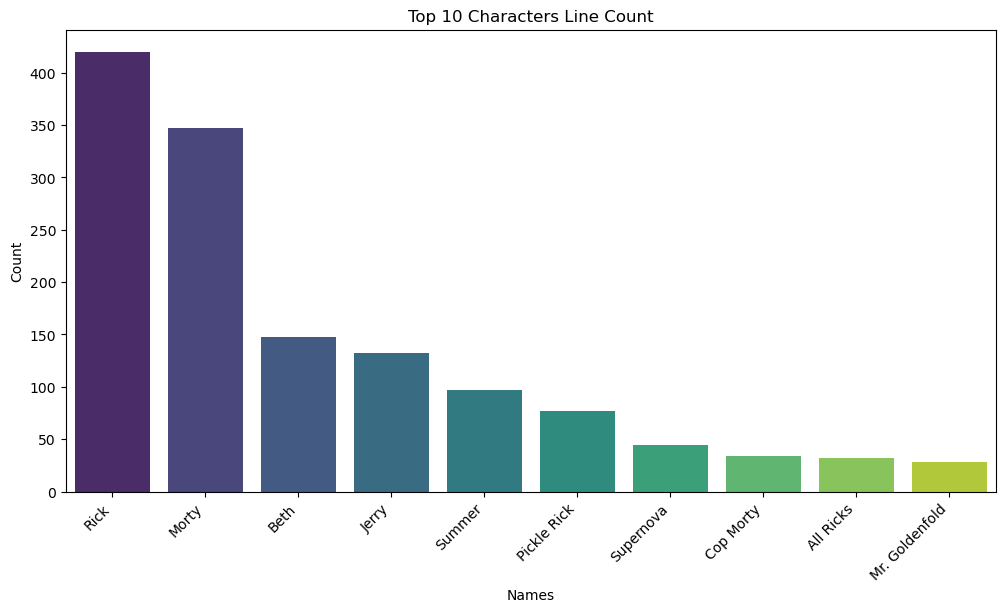

In [5]:
top_names = df['name'].value_counts().nlargest(10).index

filtered_data = df[df['name'].isin(top_names)]

plt.figure(figsize=(12, 6))  
ax = sns.countplot(data=filtered_data, x='name', order=top_names, palette='viridis')

ax.set(xlabel='Names', ylabel='Count', title='Top 10 Characters Line Count')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
plt.show()

In [6]:
import nltk
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import contractions

sw = set(stopwords.words('english'))

def remove_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in sw])

def apply_re(df, column):
    tokenizer = TweetTokenizer()
    transformed_column = 'normalized'
    df[transformed_column] = df[column]
    df[transformed_column] = df[transformed_column].apply(lambda text: remove_stopwords(text))
    df[transformed_column] = df[transformed_column].apply(lambda text: contractions.fix(text))
    df[transformed_column] = df[transformed_column].str.lower()
    df[transformed_column] = df[transformed_column].str.replace(r"http\S+", " ", regex=True)
    df[transformed_column] = df[transformed_column].str.replace(r'\d+', '')
    df[transformed_column] = df[transformed_column].str.replace('[^A-Za-z0-9]+', ' ', regex=True)
    df[transformed_column] = df[transformed_column].apply(lambda text: ' '.join(tokenizer.tokenize(text)))
    df[transformed_column] = df[transformed_column].apply(lambda text: remove_stopwords(text))
    df[transformed_column] = df[transformed_column].str.strip()
    return df

transformed_column = 'normalized'
df = apply_re(df,'line')
df[transformed_column].head(10)

0                          morty got come jus got come
1                                           rick going
2                                   got surprise morty
3                                 middle night talking
4                         come got surprise come hurry
5                                   ow ow tugging hard
6         got go got get outta come got surprise morty
7    think flying vehicle morty built outta stuff f...
8                             yeah rick great surprise
9                    morty make bomb morty create bomb
Name: normalized, dtype: object

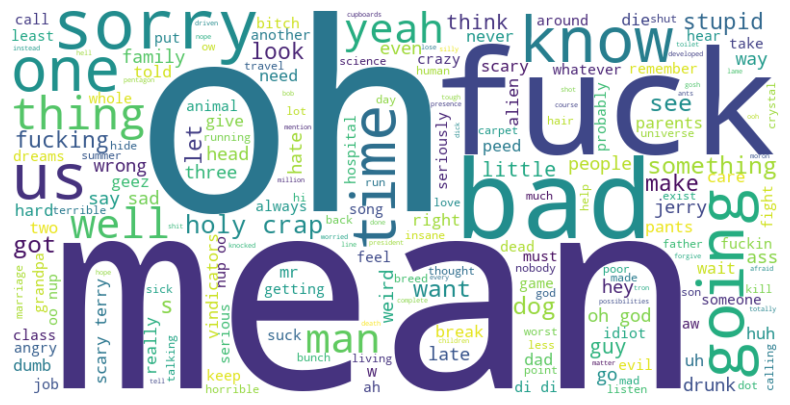

In [7]:
import nltk
from nltk import ngrams
from nltk.sentiment import SentimentIntensityAnalyzer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from textblob import TextBlob
import re
df[transformed_column] = df[transformed_column].astype(str) 
                                                                                                                             
tokenizer = TweetTokenizer()
df['tokens'] = df[transformed_column].apply(lambda text: tokenizer.tokenize(text))

df['sentiment'] = df[transformed_column].apply(lambda text: TextBlob(text).sentiment.polarity)

negative_lines = df[df['sentiment'] < -0.2][transformed_column]

negative_text = ' '.join(negative_lines)

exclude_words = ['rick', 'morty']
for word in exclude_words:
    negative_text = negative_text.replace(word, '')

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(negative_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

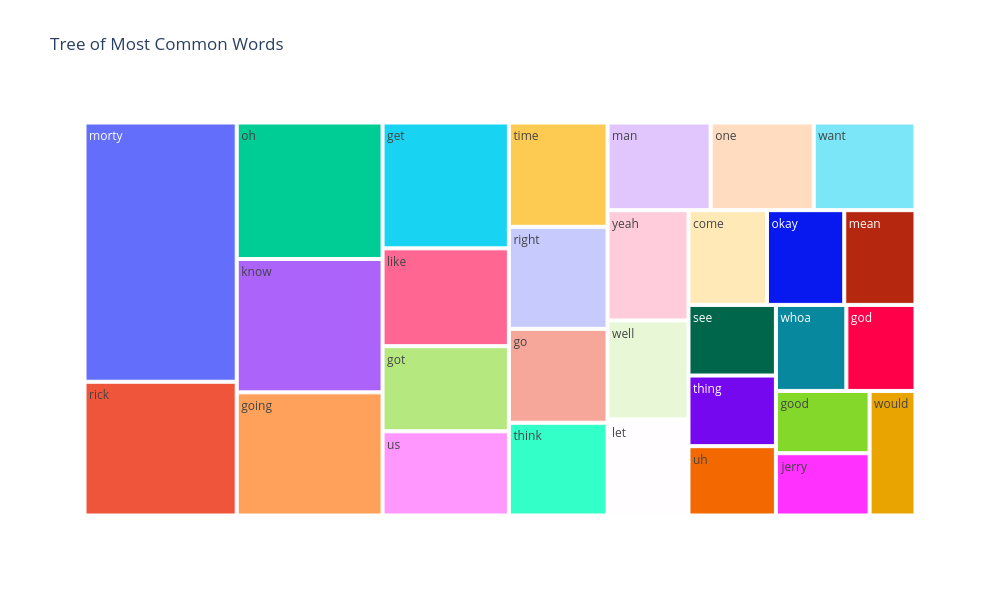

In [20]:
import itertools
import collections
import plotly.express as px
lem_list = list(df['tokens'])
token_list = list(itertools.chain(*lem_list))
counts = collections.Counter(token_list)
clean_df = pd.DataFrame(counts.most_common(30), columns=['words','count'])
clean_df_sorted = clean_df.sort_values(by='count', ascending=False)

fig = px.treemap(clean_df_sorted, path=['words'], values='count', title='Tree of Most Common Words')
fig.update_layout(width=1000, height=600)
fig.show('png')

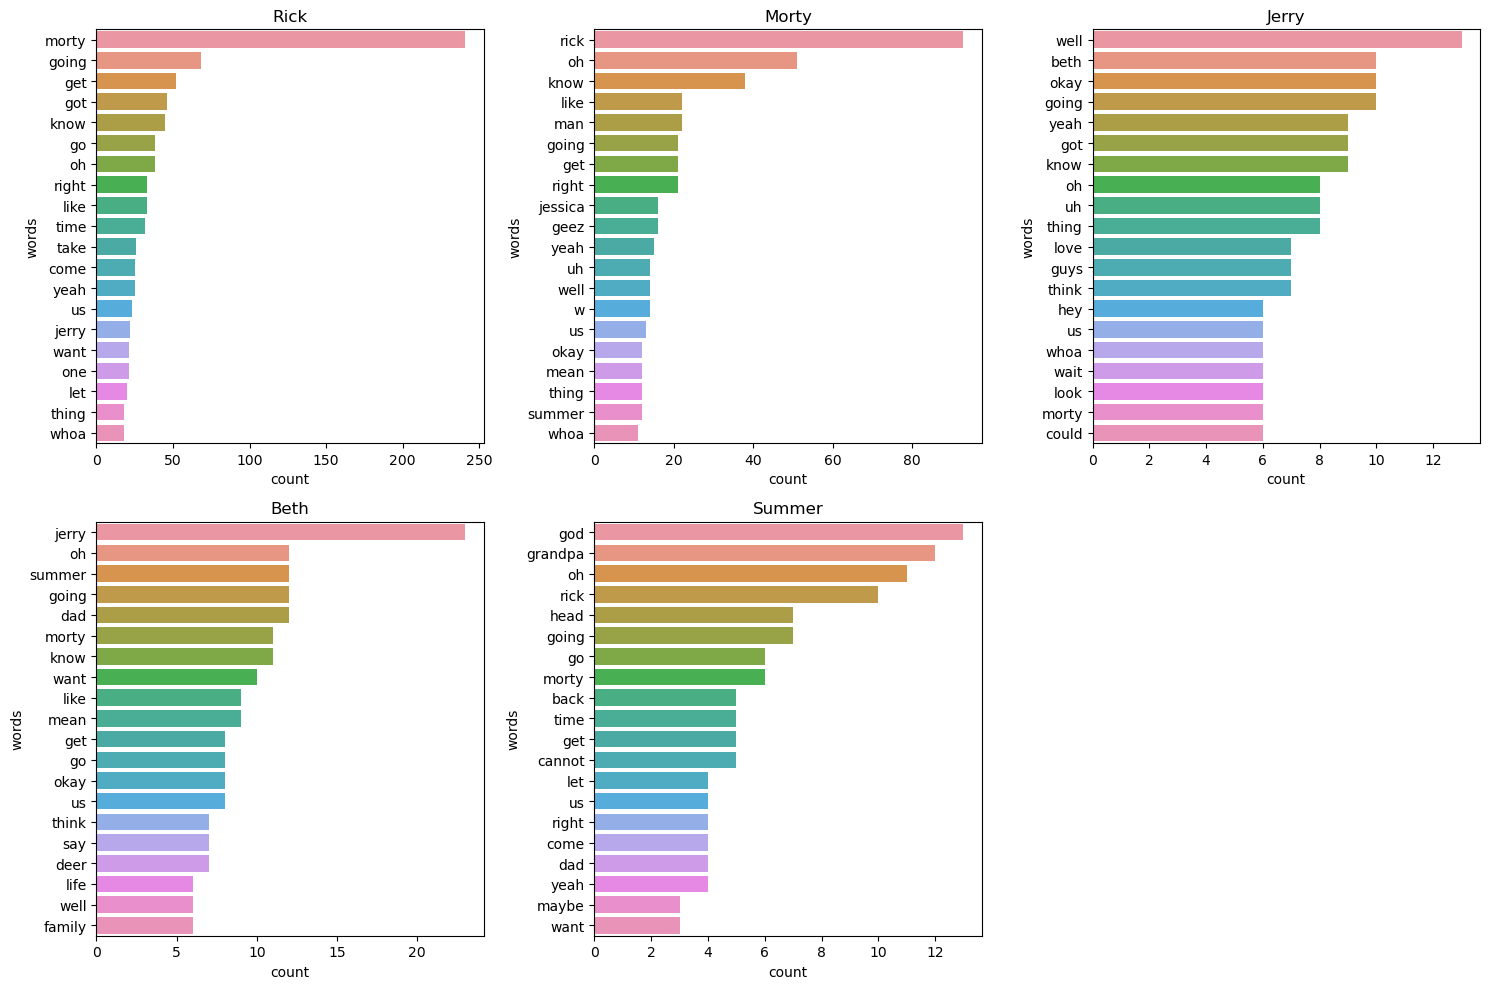

In [9]:
def plot_character_subplots(character_name, df, ax):
    character_df = df[df['name'] == character_name]
    lem_list = list(character_df['tokens'])
    token_list = list(itertools.chain(*lem_list))
    counts = collections.Counter(token_list)

    clean_df = pd.DataFrame(counts.most_common(20), columns=['words', 'count']).sort_values(by='count', ascending=False)

    sns.barplot(x='count', y='words', data=clean_df, ax=ax)
    ax.set_title(character_name)

target_characters = ['Rick', 'Morty', 'Jerry', 'Beth', 'Summer']

num_rows = 2
num_cols = 3
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 10))

axes = axes.flatten()

for i, character in enumerate(target_characters):
    plot_character_subplots(character, df, axes[i])

for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

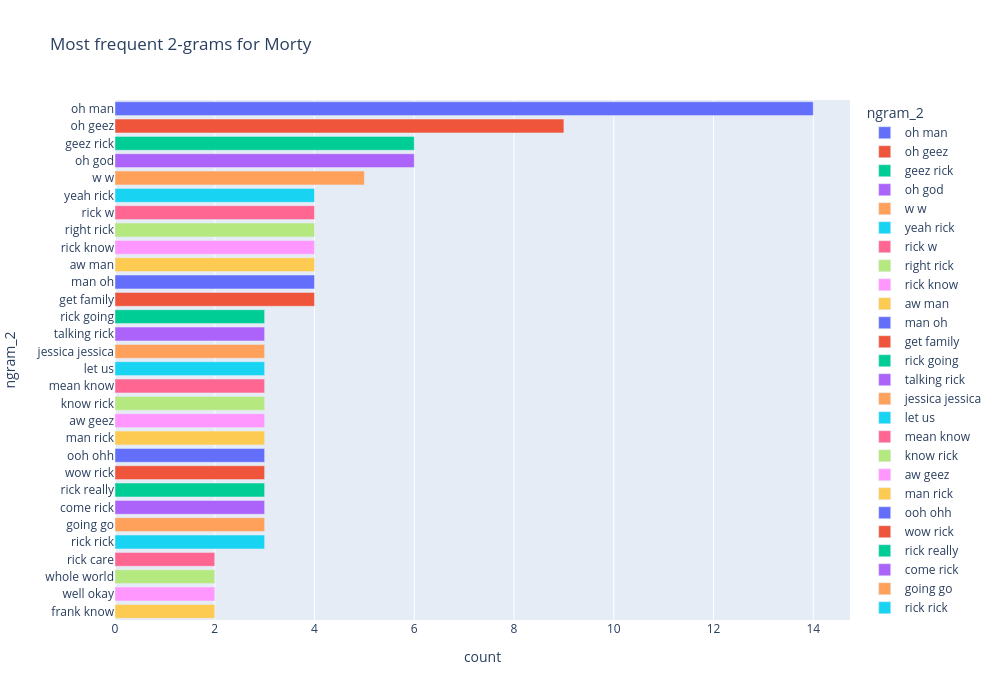

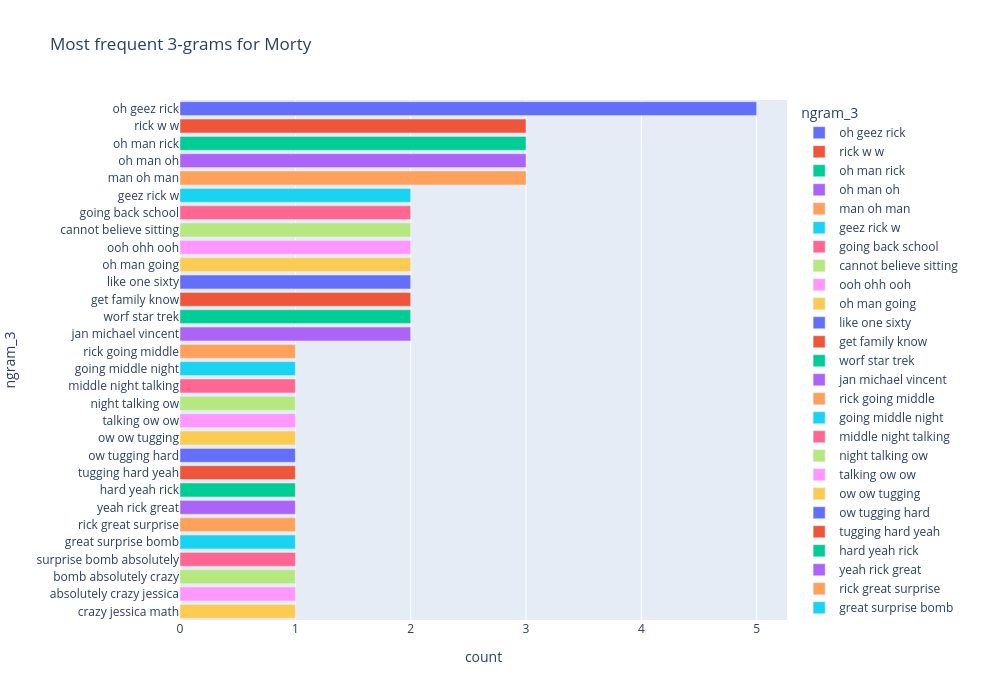

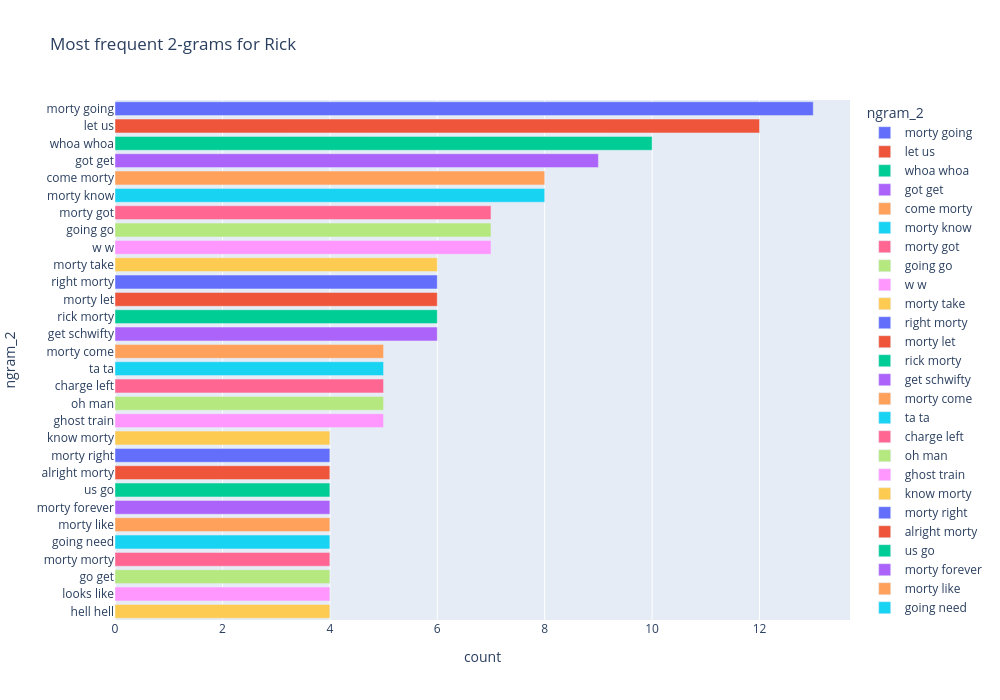

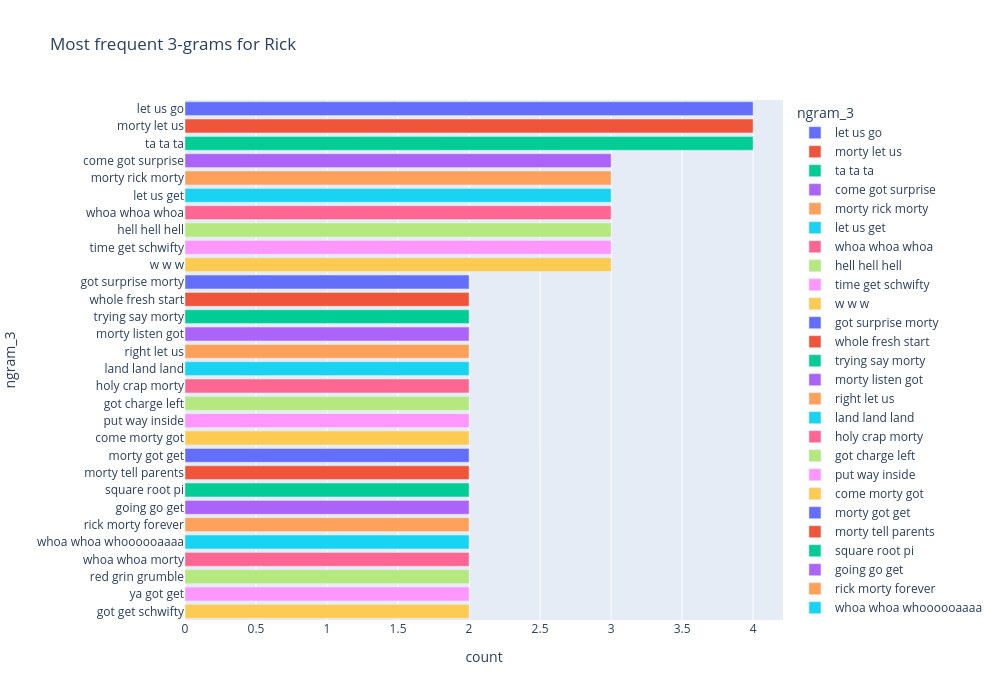

In [63]:
from nltk import bigrams, trigrams
from collections import Counter

def clean_text(text):
    text = re.sub(r'[(),]', '', text)
    return text

def extract_and_count_ngrams(df, column_name, n):
    
    all_tokens = [token for token_list in df[column_name] for token in token_list]

    if n == 2:
        ngrams = list(bigrams(all_tokens))
    elif n == 3:
        ngrams = list(trigrams(all_tokens))
    else:
        raise ValueError("Unsupported value of n. Use 2 for bigrams or 3 for trigrams.")

    cleaned_ngrams = [clean_text(' '.join(ngram)) for ngram in ngrams]

    ngram_counts = Counter(cleaned_ngrams)
    
    most_common_ngrams_df = pd.DataFrame(ngram_counts.most_common(30), columns=[f'ngram_{n}', 'count'])

    return most_common_ngrams_df


def plot_ngrams(df, name, n):
    result_ngrams = extract_and_count_ngrams(df[df['name']==name], 'tokens', n)

    fig = px.bar(result_ngrams, x="count", y=f"ngram_{n}", 
                 title=f'Most frequent {n}-grams for {name}', orientation='h', 
                 width=1000, height=700, color=f"ngram_{n}")
    
    fig.show('png')

names = ['Morty', 'Rick']

for name in names:
    plot_ngrams(df, name, 2)
    plot_ngrams(df, name, 3)

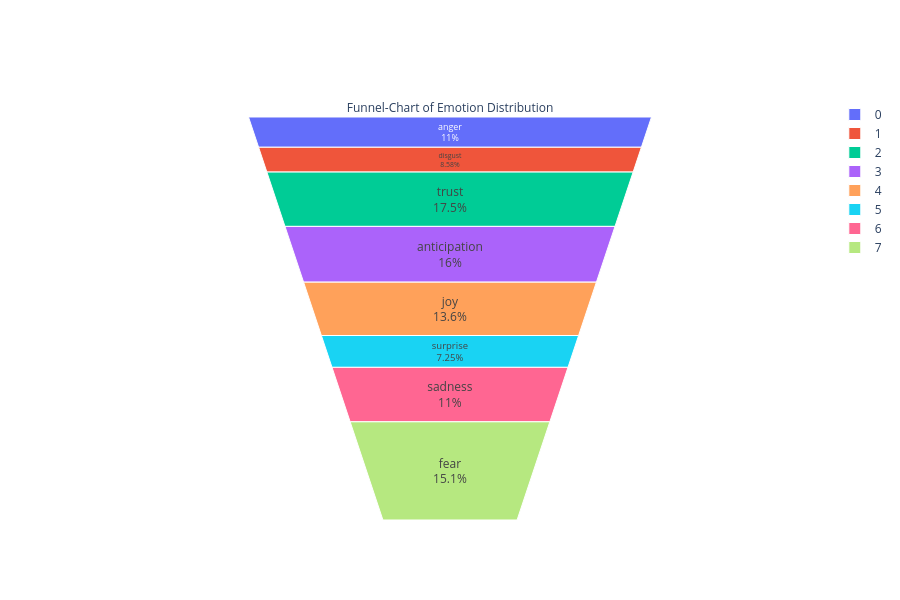

In [23]:
from nrclex import NRCLex
import plotly.graph_objects as go
import plotly.offline as pyo
total_emotion_scores = {emotion: 0 for emotion in ['anger', 'disgust', 'trust', 'anticipation', 'joy', 'surprise', 'sadness', 'fear','negative','positive']}

for line in df['normalized']:
    emotion = NRCLex(line)
    for e, score in emotion.raw_emotion_scores.items():
        total_emotion_scores[e] += score

total_scores_df = pd.DataFrame([total_emotion_scores])
emotions_to_drop = ['positive','negative']
total_scores_df.drop(emotions_to_drop, axis=1, inplace=True)

fig = go.Figure(go.Funnelarea(
    text=list(total_scores_df.columns),
    values=total_scores_df.values.flatten(),
    title={"position": "top center", "text": "Funnel-Chart of Emotion Distribution"}
))

fig.update_layout(width=900, height=600)
fig.show('png')

In [11]:
character_lines_count = df.groupby('name')['line'].count()

max_lines_character = character_lines_count.idxmax()

target_lines_count = min(character_lines_count[target_characters])

adjusted_lines = []

for character in target_characters:
    lines_to_keep = df[df['name'] == character].sample(target_lines_count, replace=True)
    adjusted_lines.extend(lines_to_keep['line'])

family_df = pd.DataFrame({'line': adjusted_lines, 'name': target_characters * target_lines_count})

for name in target_characters:
    lines = family_df[family_df['name'] == name]['line']

    total_emotion_scores = {}

    for line in lines:
        emotion = NRCLex(line)
        
        for e, score in emotion.affect_frequencies.items():
            if e in total_emotion_scores:
                total_emotion_scores[e] += score
            else:
                total_emotion_scores[e] = score

    most_dominant_emotion = max(total_emotion_scores, key=total_emotion_scores.get)

    print(f'{name}: Most dominant emotion - {most_dominant_emotion} ({total_emotion_scores[most_dominant_emotion]})')

Rick: Most dominant emotion - positive (10.452380952380953)
Morty: Most dominant emotion - negative (7.977258852258853)
Jerry: Most dominant emotion - positive (11.40258445258445)
Beth: Most dominant emotion - positive (10.204040404040406)
Summer: Most dominant emotion - negative (11.951923076923077)


In [12]:
result_data = []
for name in target_characters:
    
    lines = family_df[family_df['name'] == name]['line']

    total_emotion_scores = {}

    for line in lines:
        emotion = NRCLex(line)
        
        for e, score in emotion.raw_emotion_scores.items():
            if e in total_emotion_scores:
                total_emotion_scores[e] += score
            else:
                total_emotion_scores[e] = score

    top_emotions = sorted(total_emotion_scores, key=total_emotion_scores.get, reverse=True)[:6]

    result_dict = {'name': name}
    
    result_dict = {'name': name}
    for emotion, score in total_emotion_scores.items():
        result_dict[emotion] = score

    result_data.append(result_dict)


result_df = pd.DataFrame(result_data)

result_df

,name,positive,joy,trust,anger,disgust,fear,negative,sadness,surprise,anticipation
0,Rick,41,24,26,29,24,30,45,27,14,23
1,Morty,30,13,19,7,6,13,25,10,8,15
2,Jerry,39,20,29,18,17,21,36,15,10,29
3,Beth,46,25,36,18,14,21,40,20,7,23
4,Summer,36,20,26,16,12,18,34,18,5,27


In [13]:
from math import pi

emotions_to_drop = ['positive','negative']
cleaned_df = result_df.iloc[:5, :]
cleaned_df.drop(emotions_to_drop, axis=1, inplace=True)
cleaned_df

,name,joy,trust,anger,disgust,fear,sadness,surprise,anticipation
0,Rick,24,26,29,24,30,27,14,23
1,Morty,13,19,7,6,13,10,8,15
2,Jerry,20,29,18,17,21,15,10,29
3,Beth,25,36,18,14,21,20,7,23
4,Summer,20,26,16,12,18,18,5,27


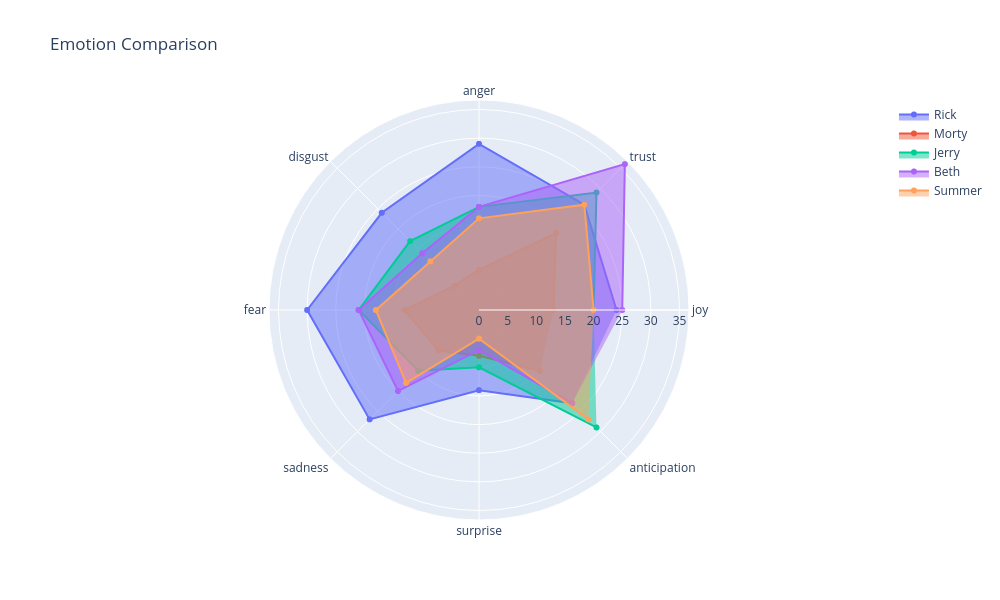

In [24]:
from plotly.offline import init_notebook_mode, iplot
from sklearn.preprocessing import MinMaxScaler
init_notebook_mode(connected=True)

fig = go.Figure()

for index, row in cleaned_df.iterrows():
    fig.add_trace(go.Scatterpolar(
        r=row[1:],
        theta=cleaned_df.columns[1:],
        fill='toself',
        name=row['name']
    ))

fig.update_layout(
    title=go.layout.Title(text='Emotion Comparison'),
    polar={'radialaxis': {'visible': True}},
    showlegend=True
)

fig.update_layout(width=1000, height=600)
fig.show('png')

In [71]:
season_emotion_stats = []

unique_seasons = df['season no.'].unique()
for season in unique_seasons:
    lines = df[df['season no.'] == season]['normalized']
    emotion_frequencies = {}
    for line in lines:
        emotion = NRCLex(line)
        
        for e in emotion.raw_emotion_scores.keys():
            if e in emotion_frequencies:
                emotion_frequencies[e] += 1
            else:
                emotion_frequencies[e] = 1

    result_df = pd.DataFrame(list(emotion_frequencies.items()), columns=['emotion', 'frequency'])
    result_df['season'] = season

    season_emotion_stats.append(result_df)

season_emotion_stats_df = pd.concat(season_emotion_stats, ignore_index=True)

season_emotion_stats_df.head()

,emotion,frequency,season
0,fear,122,1
1,joy,116,1
2,positive,182,1
3,surprise,64,1
4,anticipation,110,1


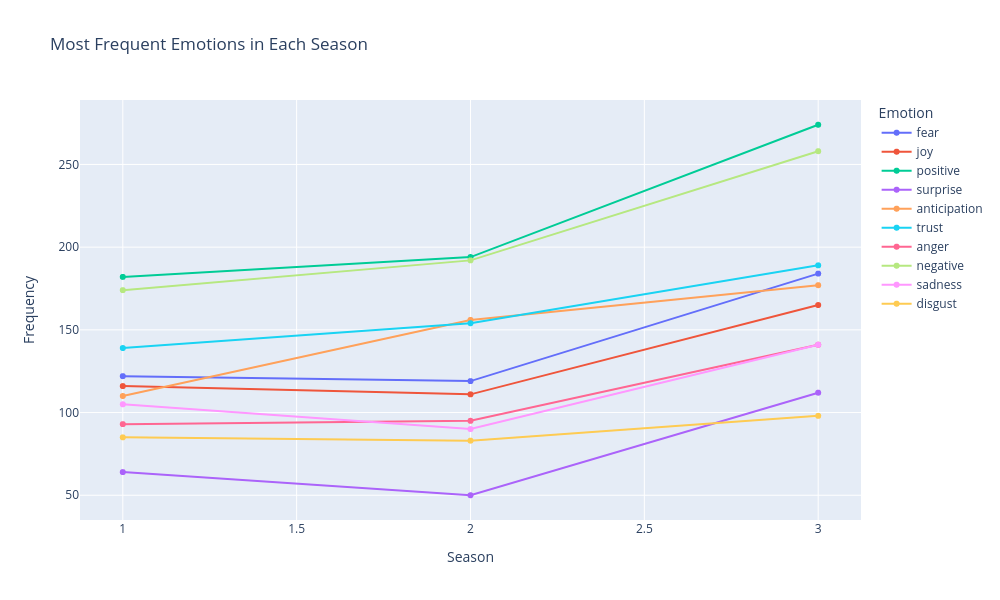

In [72]:
fig = px.line(season_emotion_stats_df, x='season', y='frequency', color='emotion', markers=True,
              labels={'frequency': 'Frequency', 'season': 'Season', 'emotion': 'Emotion'},
              title='Most Frequent Emotions in Each Season')
fig.update_layout(width=1000, height=600)
fig.show('png')

In [25]:
# dialog gpt
